# Replication of system identification with Lorenz and delay embedding (Abarbanel 1994),
## plus comparison to other methods and papers.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
import embed_dynamics
from importlib import reload
%load_ext tensorboard
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mutual_info_score
import sys, importlib
from dynamics_methods import *
from embedding_methods import *
from scipy.stats import entropy
from scipy.signal import argrelextrema
from scipy.signal import find_peaks


# Update on 0812: Running Lorenz with newer versions of network module

In [169]:
t0 = 0
t1 = 100 
dt = 0.01
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]
init_list = [ np.array([5, 0, 25]), np.array([2, 5, 43]) ]
u_names = ['.']
pred = 100

# Abarbanel's parameters
sigma=16
rho=45.92
beta=4
lsys = embed_dynamics.LorenzFullStateD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
sys_list = [lsys]
sys_names = ['Lorenz']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
# A quick and dirty way to add another "test set" that uses longer time
for syst in sys_list:
    syst.add_u_func( u_func_list[0], init_list[0], (t0, t1*5, dt) )
for syst in sys_list:
    syst.data_generator()

u_names=['train0','test1','train_long']
out_names=['x','y','z']

In [381]:
reload(networks)
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["dynamics_methods"])
from dynamics_methods import *
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *

In [382]:
# Alternate code if you want to specify your own embeddings
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
# opt_args = (0.005,) # Order: (Learning rate,)
activation = 'tanh' # 'leaky relu 0.2' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
# input_masks = [ [1] ] # Reminder: index 0 is time. Index 1 is first state.
input_masks = [ [1,3] ]
# input_masks = [[3]]
Nlayer = 2
Nneuron = 20
# tts = np.array([[10,20,30,40]])
tts = np.array([[10,20,30], [10,20,30]])
js,ts = delay_embed_converter_Garcia_Cao(False, tts)
de = 3
delay_int = 10
net_listM = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
#     sys_list[i].pred = 10
    net_listM.append(
        embed_dynamics.NN_FNN(
            sys_list[i], input_masks[i], ratio=10, stop_threshold=0, min_tau=1, max_tau=100, max_de=10, verbose=True,
            fnn_ind=0, FNNtype='kennel', uniform_delay=False, inverse=True, 
            delay_vars=(js, ts, tts),
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg#, opt_args=opt_args,
            , pred=0
        ))
    net_listM.append(
        embed_dynamics.NN_Delay(
            sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, loss='mse', pred=0, 
            de=de, delay_int=delay_int #, sym=True
        )
#         embed_dynamics.NN_Delay(
#             sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
#             Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
#             optimizer=opt_alg, loss='mse', pred=0, 
#             de=5, delay_int=-1
#         )
    )
# net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]
net_names = ['FNN','delay']

Epoch = 10#0
# Construct models
for nn in net_listM:
    nn.construct()
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9970, 8, 1); outputset size = (9970, 3, 1)
Input set is masked by  [1, 3]
Train on 9970 samples
Epoch 1/10
9970/9970 [==============================] - 7s 707us/sample - loss: 0.2953s - loss: 0.3
Epoch 2/10
9970/9970 [==============================] - 0s 38us/sample - loss: 0.1169
Epoch 3/10
9970/9970 [==============================] - 0s 35us/sample - loss: 0.0942
Epoch 4/10
9970/9970 [==============================] - 0s 35us/sample - loss: 0.0773
Epoch 5/10
9970/9970 [==============================] - 0s 43us/sample - loss: 0.0626
Epoch 6/10
9970/9970 [==============================] - 0s 37us/sample - loss: 0.0506
Epoch 7/10
9970/9970 [==============================] - 0s 35us/sample - loss: 0.0423
Epoch 8/10
9970/9970 [==============================] - 0s 35us/sample - loss: 0.0362
Epoch 9/10
9970/9970 [==============================] - 0s 34us/sample - loss: 0.0316
Epoch 10/10
9970/9970 [==============================] - 0s 34us/sample - loss: 0.0280
Model: "sequ

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - params[0][i]) / params[1][i]


Train on 9980 samples
Epoch 1/10
9980/9980 [==============================] - 1s 83us/sample - loss: 0.2974
Epoch 2/10
9980/9980 [==============================] - 0s 38us/sample - loss: 0.1131
Epoch 3/10
9980/9980 [==============================] - 0s 38us/sample - loss: 0.0916
Epoch 4/10
9980/9980 [==============================] - 0s 35us/sample - loss: 0.0761
Epoch 5/10
9980/9980 [==============================] - 0s 37us/sample - loss: 0.0633
Epoch 6/10
9980/9980 [==============================] - 0s 40us/sample - loss: 0.0529
Epoch 7/10
9980/9980 [==============================] - 0s 38us/sample - loss: 0.0447
Epoch 8/10
9980/9980 [==============================] - 0s 34us/sample - loss: 0.0384
Epoch 9/10
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0334
Epoch 10/10
9980/9980 [==============================] - 0s 35us/sample - loss: 0.0295
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 

In [ ]:
for nn in net_listM:
    nn.train(epoch=400, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Dimensions: Outputset = (9970, 3, 1), results = (9970, 3, 1)


<Figure size 432x288 with 0 Axes>

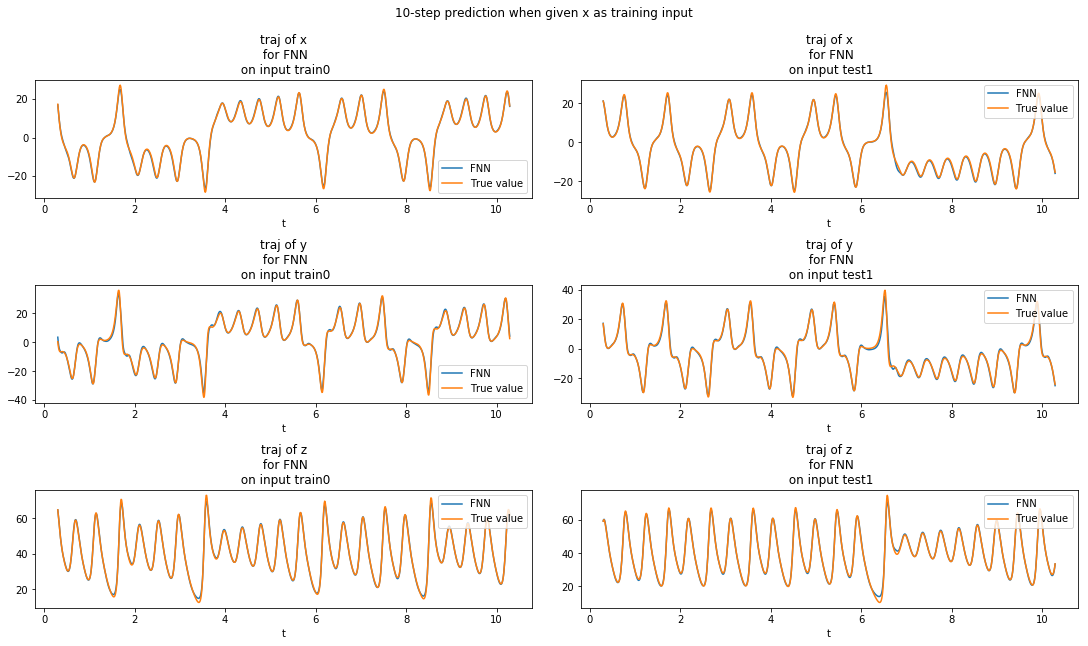

In [386]:
fig, axs, rlist = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[0], out_list=[0,1,2], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=10/dt,
                       title='10-step prediction when given x as training input\n' )

Dimensions: Outputset = (9970, 3, 1), results = (9970, 3, 1)


<Figure size 432x288 with 0 Axes>

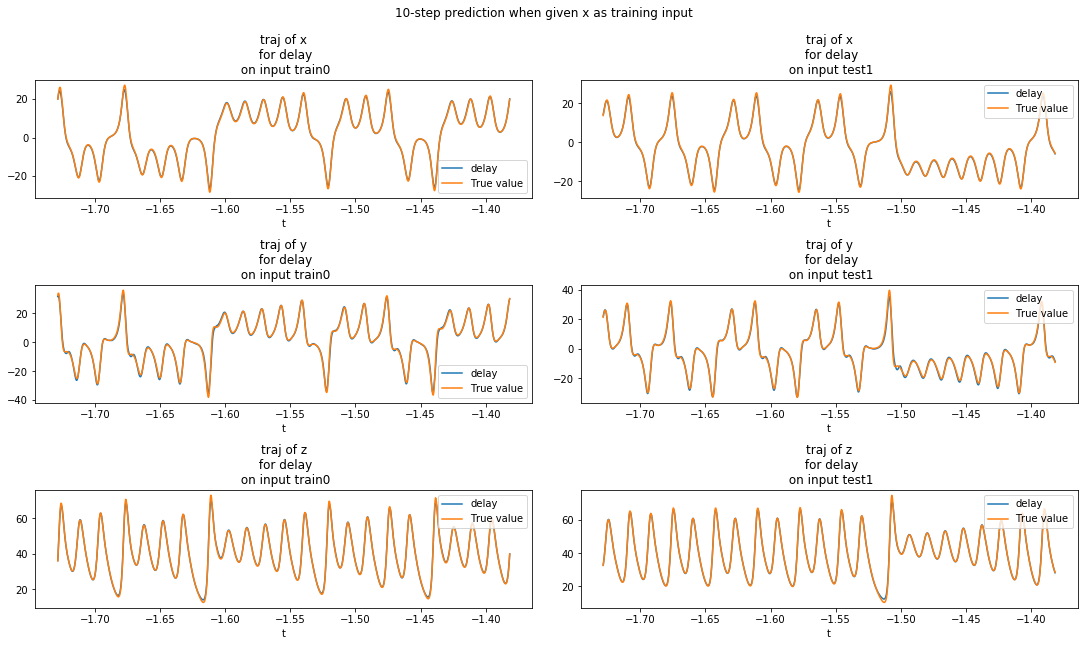

In [387]:
fig, axs, rlist1 = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=10/dt,
                       title='10-step prediction when given x as training input\n' )

Dimensions: Outputset = (9970, 3, 1), results = (9970, 3, 1)


<Figure size 432x288 with 0 Axes>

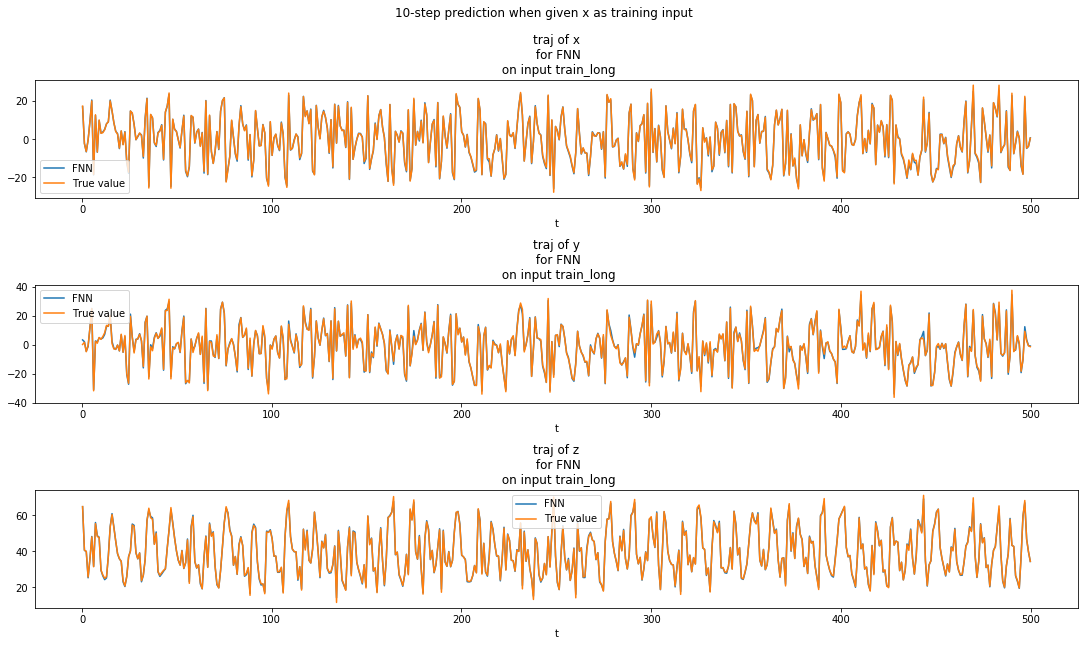

In [389]:
# Plots the test dataset with very long time range
fig, axs, _ = plot_tests( test_inds=[2], net_list=net_listM, net_inds=[0], out_list=[0,1,2], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=97, 
                       title='10-step prediction when given x as training input\n' )

# Below are old code before 0812

## Training data generation

In [30]:
reload(system_dynamics)
reload(networks)

<module 'networks' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/networks.py'>

In [156]:
t0 = 0
t1 = 100 # The original paper used 2000? 10000*0.02? They conflict with themselves.
dt = 0.01 # The original paper used 0.02, but I don't think it matters
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]
init_list = [ np.array([5, 0, 25]), np.array([2, 5, 43]) ]
u_names = ['.']

# Which parameters to use? Let's see what happens with Abarbanel's parameters first.
sigma=16
rho=45.92
beta=4
lorenz_sys = system_dynamics.Lorenz(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta)
# We also try to see if other state variables could be inferred.
lorenz_full_sys = system_dynamics.LorenzFullState(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta)
sys_list = [lorenz_sys, lorenz_full_sys]
sys_names = ['Lorenz z', 'Lorenz full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
    syst.data_generator()


In [257]:
type(lorenz_full_sys)

system_dynamics.LorenzFullState

## Plot the generated data for visual inspection

<Figure size 432x288 with 0 Axes>

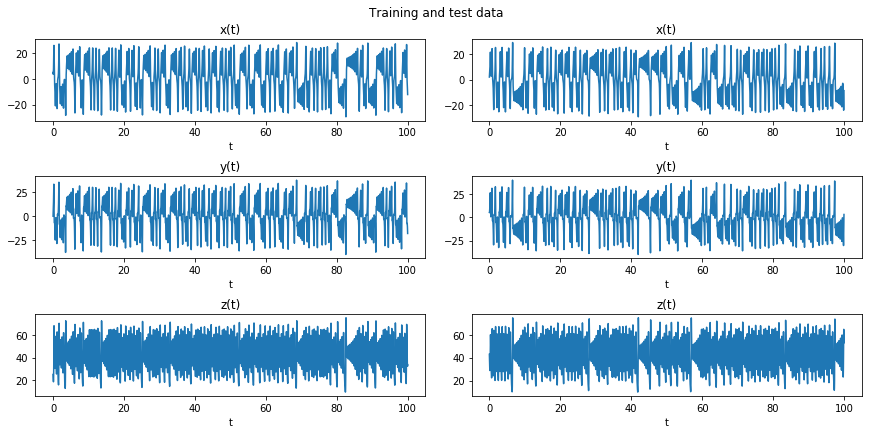

In [567]:
fig,axs = lorenz_full_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

## Generate a bunch of neural nets for learning

In [166]:
# Set up nets.
# This is where we deviate from the original paper, which used polynomial approximations instead.
# Other discrepancies with the original paper:
# - This code doesn't do a train-test split because it's too cumbersome, given the current structure. 
# - This code might consider 1-step prediction and non-symmetric embedding as well. 
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [1] # Allows x(1); doesn't allow t(0), y(2), z(3), u(4).
Nlayer = 2
Nneuron = 5
# The delay and dimension come from the original paper.
de = 3
delay_int = 10

net_list = []
for i in range(len(sys_list)):
#     sys_list[i].pred=0 # This line existed before System had attribute "pred"
    net_list.append(
#         networks.NN_Delay(
#             sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
#             Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
#             de=de, delay_int=delay_int, sym=True
#         )
        embed_dynamics.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=delay_int#, sym=True
        )
    )
net_names = [ name+'-{0}DE-{1}*{2}'.format(de, delay_int, dt) for name in sys_names]

# Construct models
for nn in net_list:
    nn.construct()


In [136]:
net_list[1].pred
sys_list[1].pred

0

In [167]:
# Train models. 
Epoch = 100
for nn in net_list:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  data = np.moveaxis(data, 0, axis)'''


Train on 9980 samples
Epoch 1/100
9980/9980 [==============================] - 1s 83us/sample - loss: 0.8512
Epoch 2/100
9980/9980 [==============================] - 0s 39us/sample - loss: 0.4527
Epoch 3/100
9980/9980 [==============================] - 0s 39us/sample - loss: 0.2024
Epoch 4/100
9980/9980 [==============================] - 0s 37us/sample - loss: 0.1225
Epoch 5/100
9980/9980 [==============================] - 0s 37us/sample - loss: 0.0867
Epoch 6/100
9980/9980 [==============================] - 0s 36us/sample - loss: 0.0698
Epoch 7/100
9980/9980 [==============================] - 0s 36us/sample - loss: 0.0604
Epoch 8/100
9980/9980 [==============================] - 0s 39us/sample - loss: 0.0540
Epoch 9/100
9980/9980 [==============================] - 0s 38us/sample - loss: 0.0493
Epoch 10/100
9980/9980 [==============================] - 0s 37us/sample - loss: 0.0457
Epoch 11/100
9980/9980 [==============================] - 0s 36us/sample - loss: 0.0430
Epoch 12/100
9980/9

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  data = np.moveaxis(data, 0, axis)'''


9980/9980 [==============================] - 1s 110us/sample - loss: 1.2028
Epoch 2/100
9980/9980 [==============================] - 0s 33us/sample - loss: 0.4694
Epoch 3/100
9980/9980 [==============================] - 0s 34us/sample - loss: 0.3389
Epoch 4/100
9980/9980 [==============================] - 0s 34us/sample - loss: 0.2703
Epoch 5/100
9980/9980 [==============================] - 0s 33us/sample - loss: 0.2015
Epoch 6/100
9980/9980 [==============================] - 0s 34us/sample - loss: 0.1473
Epoch 7/100
9980/9980 [==============================] - 0s 34us/sample - loss: 0.1169
Epoch 8/100
9980/9980 [==============================] - 0s 33us/sample - loss: 0.1012
Epoch 9/100
9980/9980 [==============================] - 0s 32us/sample - loss: 0.0912
Epoch 10/100
9980/9980 [==============================] - 0s 31us/sample - loss: 0.0836
Epoch 11/100
9980/9980 [==============================] - 0s 34us/sample - loss: 0.0771
Epoch 12/100
9980/9980 [============================

In [ ]:
net_list[0].plot_loss_history(log=True)

In [489]:
# Plotting helper function...
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*3), squeeze=False)
    figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
                # print(result.shape)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
                axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
        for i in range(Noutput):
            axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
            axst[i][j].legend(net_names)
            
    fig.suptitle(title)
    figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs

In [ ]:
# Plot systems that try to learn the full state - error plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_list, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  data = np.moveaxis(data, 0, axis)'''


<Figure size 432x288 with 0 Axes>

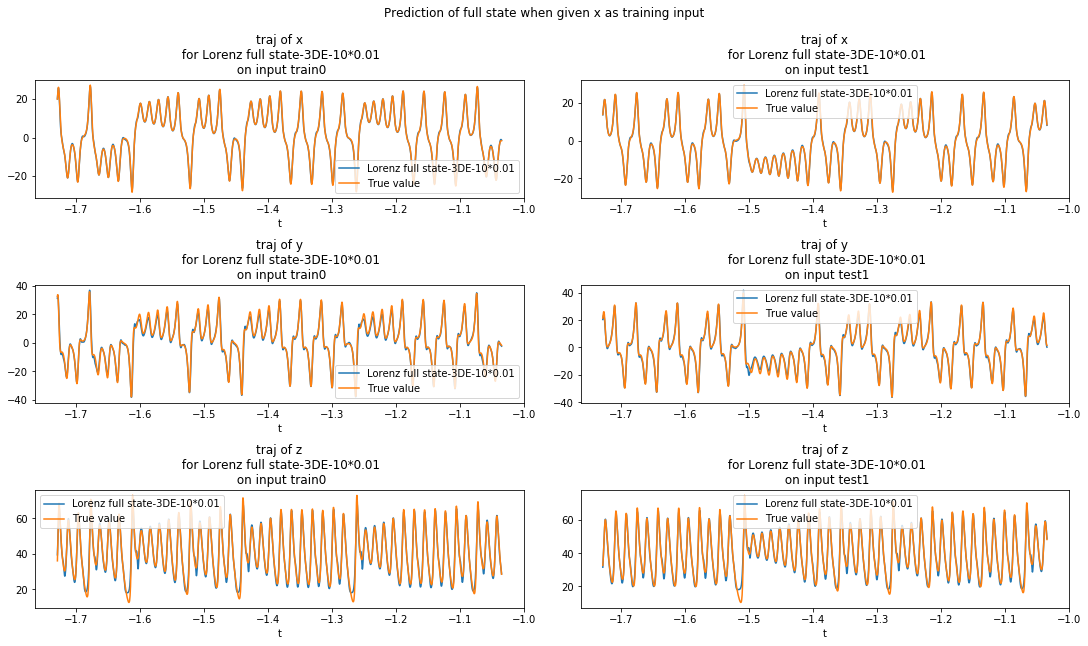

In [168]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_list, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=20/dt,
                       title='Prediction of full state when given x as training input\n' )

<Figure size 432x288 with 0 Axes>

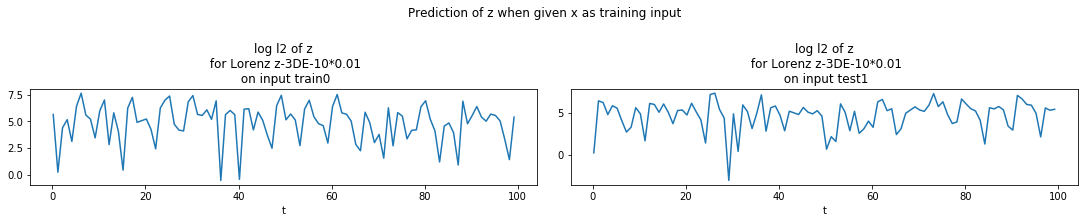

In [80]:
# Plot systems that try to learn z from x - error plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_list, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['z'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Prediction of z when given x as training input\n' )

<Figure size 432x288 with 0 Axes>

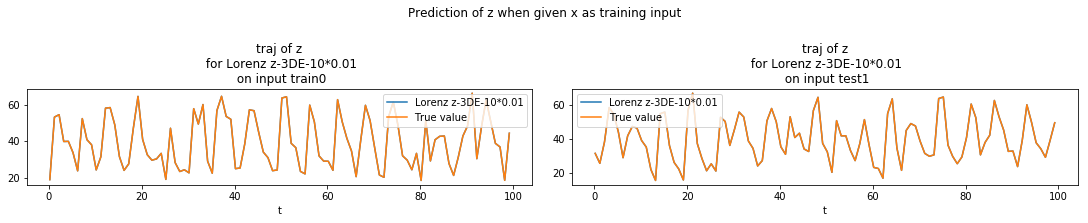

In [81]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_list, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of z when given x as training input\n' )

## Playground for AMI methods

In [131]:
X = lorenz_full_sys.Inputset[0]
X.shape

In [83]:
(X[1,:].reshape(-1,1)).shape

(10000, 3)

In [82]:
mutual_info_regression( X[1:4,:].reshape(10000,-1), X[1], discrete_features=False )

array([0.02405123, 0.01664815, 0.01141371])

In [220]:
def framing_helper(data, framelen, interv=1, stride=1, axis=1, offset=0, Nframes=-1):
    # Helper method for framing. Handles more general cases.
    # Puts a data into multiple frames.
    # framelen: Length of each frame
    # interv  : Number of samples between neighboring frames
    # stride  : How many sample to go between two neighboring samples within a frame
    # axis    : Axis that's being framed
    # Example: Input is data=[1,2,3,4,5,6,7], N=3, interv=2, stride=1, then
    # output would be [ [1,2,3], [3,4,5], [5,6,7] ].
    # This method doesn't do error checking.
    if Nframes < 0:
        Nframes = int(np.ceil( (data.shape[axis] - (framelen-1)*stride - offset) / interv ))
    set_inds = [slice(None)]*data.ndim # https://stackoverflow.com/questions/42656930/numpy-assignment-like-numpy-take
    take_inds = set_inds[:]
    frames = np.zeros( tuple( [Nframes] + list( data.shape[:axis]) + [framelen] + list(data.shape[axis+1:] ) ) )

    for i in range(Nframes):
        set_inds[axis] = i
        take_inds[axis] = slice( i*interv+offset, i*interv+framelen*stride+offset, stride )
        frames[i] = data[tuple(take_inds)]
    return frames

    def delay_embed(data, dt_int, de, symmetric=False):
        if symmetric:
            offset = de-1 - (de//2)
        else:
            offset = de-1
            
        dembed_out = framing_helper(data, 1, stride=dt_int, offset=offset)
        return dembed_out

def find_delay(data, max_delay):
    if len(data.shape) == 1:
        data = data.reshape(-1,1)
    else:
        data = data.T # Ending shape should be (Nsamples, Nfeatures)
    prev_cor = mutual_info_regression(data, data[:,0])[0]*100
    local_min_found = False
    local_min_delay = 0
    
    for t in range(1, max_delay+1):
        # Currently only works with 1D data...
        x1 = data[:-t]
        x2 = data[t:,0]
        curr_cor = mutual_info_regression(x1, x2)
        curr_cor = curr_cor[0]
        
        if curr_cor >= prev_cor:
            local_min_found = True
        if curr_cor < prev_cor and not local_min_found:
            local_min_delay = t
        
        prev_cor = curr_cor
        print(t, curr_cor)
        
    return local_min_delay, local_min_found


In [ ]:
find_delay( X[3], 100 )

In [ ]:
# File location of mutual info regression: 
# /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/_mutual_info.py

In [88]:
mutual_info_regression( X[1:2,:].reshape(10000,-1), X[1], discrete_features=False )

array([7.9541727])

In [ ]:
# scipy version
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
sckde1 = gaussian_kde(X[1])
testset = np.arange(-30, 30, 1)
testresult = sckde1.pdf(testset)
print(testresult)
# The result is a PDF at each value. Plot it out (it uses log scale):
plt.plot(testset, testresult)
plt.title('Kernel with auto Gaussian bandwidth (Scott 1993)')
plt.xlabel('Values of x(t)')
plt.ylabel('log distribution probability')

In [156]:
# MI estimation using Scipy - wrong code; see updated version below
max_delay = 20
ep = 1e-10
grid_step = 0.5
for t in range(1,max_delay):
    sckde_12 = gaussian_kde(np.vstack((X[1,:-t], X[1,t:]))) # 2D kde object
    grid1 = np.arange(np.floor(np.amin(X[1,:-t])), np.ceil(np.amax(X[1,:-t])), grid_step)
    grid2 = np.arange(np.floor(np.amin(X[1,t:])), np.ceil(np.amax(X[1,t:])), grid_step)
    # Find the pdf from the object. The matrix operations are learned from the examples of:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    Xo, Xd = np.meshgrid(grid1, grid2)
    prob12 = sckde_12.pdf( np.vstack( (Xo.ravel(), Xd.ravel()) ) ).reshape(Xo.shape) + ep
    H12 = np.sum( prob12 * np.log(prob12) )
    # Marginal probs
    prob1 = np.sum( prob12, axis=0 )
    H1 = np.sum( prob1 * np.log(prob1) )
    prob2 = np.sum( prob12, axis=1 )
    H2 = np.sum( prob2 * np.log(prob2) )
    # Get MI value
    MI = H12 - H1 - H2
    print(MI, t)

4.796985644255981 1
2.071851615942208 2
0.5228407329344869 3
-0.5339560489237556 4
-1.314751727182232 5
-1.9161633793019668 6
-2.388524232849443 7
-2.7608079442793336 8
-3.051654094509704 9
-3.274537759166801 10
-3.4400363034426373 11
-3.5568619180735705 12
-3.63257326888618 13
-3.6743013351546665 14
-3.6894509671124283 15
-3.686151245922881 16
-3.6732316794361033 17
-3.659684265385078 18
-3.6538138609297324 19


In [157]:
H12, H1, H2

(-29.38679126507534, -12.865779528372734, -12.867197875772872)

In [ ]:
# sklearn version https://scikit-learn.org/stable/modules/density.html
# I think it should only take in 1D inputs at one time; otherwise it treats high-dimensional data as a whole.
skkde1 = KernelDensity(kernel='gaussian', bandwidth=2).fit(X[1].reshape(-1,1)) # Bandwidth needs tuning
# The object has now stored the data. The next thing is to see the probability it interpolated.
testset = np.arange(-30, 30, 1)
testresult = skkde1.score_samples(testset.reshape(-1,1))
print(testresult)
# The result is a PDF at each value. Plot it out (it uses log scale):
plt.plot(testset, testresult)
plt.title('Kernel with Gaussian bandwidth = 2')
plt.xlabel('Values of x(t)')
plt.ylabel('log distribution probability')

In [215]:
# MI estimation using sklearn - wrong code; see updated version below
max_delay = 20
ep = 1e-10
grid_step = 1
for t in range(10,max_delay):
    # Added ".T" at the end because sklearn's KernelDensity is different...
    skkde_12 = KernelDensity(kernel='gaussian', bandwidth=2).fit(np.vstack((X[1,:-t], X[1,t:])).T)
    grid1 = np.arange(np.floor(np.amin(X[1,:-t])), np.ceil(np.amax(X[1,:-t])), grid_step)
    grid2 = np.arange(np.floor(np.amin(X[1,t:])), np.ceil(np.amax(X[1,t:])), grid_step)
    # Find the pdf from the object. The matrix operations are learned from the examples of:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    Xo, Xd = np.meshgrid(grid1, grid2)
    prob12 = skkde_12.score_samples( np.vstack( (Xo.ravel(), Xd.ravel()) ).T ).reshape(Xo.shape) + ep
    # sklearn's KernelDensity also automatically uses log, so...
    prob12 = np.exp(prob12)
    H12 = np.sum( prob12 * np.log(prob12) )
    # Marginal probs
    prob1 = np.sum( prob12, axis=0 )
    H1 = np.sum( prob1 * np.log(prob1) )
    prob2 = np.sum( prob12, axis=1 )
    H2 = np.sum( prob2 * np.log(prob2) )
    # Get MI value
    MI = H12 - H1 - H2
    print(MI, t)

-3.1930315892156713 10


In [ ]:
# sklearn version https://scikit-learn.org/stable/modules/density.html
# I think it should only take in 1D inputs at one time; otherwise it treats high-dimensional data as a whole.
skkde2 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X[1].reshape(-1,1)) # Bandwidth needs tuning
# The object has now stored the data. The next thing is to see the probability it interpolated.
testset = np.arange(-30, 30, 1)
testresult = skkde2.score_samples(testset.reshape(-1,1))
print(testresult)
# The result is a PDF at each value. Plot it out (it uses log scale):
plt.plot(testset, testresult)
plt.title('Kernel with Gaussian bandwidth = 0.2')
plt.xlabel('Values of x(t)')
plt.ylabel('log distribution probability')

In [194]:
# Histogram fixed bin version
# Source: https://stackoverflow.com/a/20505476
max_delay = 20
ep = 1e-10
grid_step = 1
for t in range(1,max_delay):
    H, edge_Xo, edge_Xd = np.histogram2d( X[1,:-t], X[1,t:], bins=100)#, density=True )
    MI = mutual_info_score(None, None, contingency=(H+ep))
    print(MI, t)
# Note: You can choose density=True or normal=True (only choose one of them, not both), where
# the end result would sum up to (1 / bin area). However, this might not work well with mutual_info_score.


2.6824770048506217 1
2.142263267702919 2
1.8230350001650857 3
1.610860257500833 4
1.4539146662950733 5
1.3306901020256925 6
1.2393573282054193 7
1.1750844387689077 8
1.129444523901752 9
1.1121067525593515 10
1.1292811789773887 11
1.1953410422027235 12
1.2890841115151361 13
1.3399225138234285 14
1.3436492766279038 15
1.3214069485817679 16
1.306951847750279 17
1.2992133292829853 18
1.2892382958116015 19


In [192]:
np.sum(H)*0.57977*0.57977

3360.9963957471005

In [177]:
edge_Xo[-1]-edge_Xo[0]

57.97715763487368

In [195]:
mutual_info_score(None, None, contingency=(H+ep))

1.2892382958116015

In [203]:
# Play more on the binned hsitogram version
max_delay = 20
ep = 1e-10
grid_step = 1
Nbin = 100
for t in range(1,max_delay):
    Hi, edge_Xo, edge_Xd = np.histogram2d( X[1,:-t], X[1,t:], bins=Nbin, density=True )
    # Normalize the frequencies so that they qualify as probabilities
    bin_area = (edge_Xo[-1]-edge_Xo[0])/Nbin * (edge_Xd[-1]-edge_Xd[0])/Nbin
    Hi = Hi * bin_area + ep
    # Calculate H(X,Y) from Hi, which just became the probabilities
    H12 = np.sum( Hi * np.log(Hi) )
    # Marginal probs
    prob1 = np.sum( Hi, axis=0 )
    H1 = np.sum( prob1 * np.log(prob1) )
    prob2 = np.sum( Hi, axis=1 )
    H2 = np.sum( prob2 * np.log(prob2) )
    # Get MI value
    MI = H12 - H1 - H2
    print(MI, t)

2.6824631238197503 1
2.142250313892755 2
1.8230227884308876 3
1.6108486232498773 4
1.4539035141418593 5
1.3306793006827045 6
1.2393467969889356 7
1.1750740718925243 8
1.129434266984088 9
1.1120964874907644 10
1.1292707903027246 11
1.1953305000267092 12
1.289073398727811 13
1.3399117234231301 14
1.343638463462863 15
1.3213961785669204 16
1.3069410692776184 17
1.299202554790246 18
1.2892275073678805 19


In [199]:
np.sum(Hi)

2.9749944510190796

In [209]:
np.sum( prob12 * np.log(prob12) )
# Marginal probs
prob1 = np.sum( prob12, axis=0 )
H1 = np.sum( prob1 * np.log(prob1) )
prob2 = np.sum( prob12, axis=1 )
H2 = np.sum( prob2 * np.log(prob2) )

In [256]:
np.sum(prob12)# / grid_step1 / grid_step2 

0.9897993433604598

In [253]:
# MI estimation using Scipy - this code still needs some debugging for now.
max_delay = 20
ep = 1e-10
Nbin = 100
for t in range(1,max_delay):
    grid_step1 = (np.amax(X[1,:-t]) - np.amin(X[1,:-t])) / Nbin
    grid1 = np.arange(np.amin(X[1,:-t]), np.amax(X[1,:-t]), grid_step1)
    grid_step2 = (np.amax(X[1,t:]) - np.amin(X[1,t:])) / Nbin
    grid2 = np.arange(np.amin(X[1,t:]), np.amax(X[1,t:]), grid_step2)
    
    sckde_12 = gaussian_kde(np.vstack((X[1,:-t], X[1,t:]))) # 2D kde object
    # Find the pdf from the object. The matrix operations are learned from the examples of:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
    Xo, Xd = np.meshgrid(grid1, grid2)
    prob12 = sckde_12.pdf( np.vstack( (Xo.ravel(), Xd.ravel()) ) ).reshape(Xo.shape) * grid_step1 * grid_step2 + ep
    H12 = np.sum( prob12 * np.log(prob12) )
    # Marginal probs
    prob1 = np.sum( prob12, axis=0 )
    H1 = np.sum( prob1 * np.log(prob1) )
    prob2 = np.sum( prob12, axis=1 )
    H2 = np.sum( prob2 * np.log(prob2) )
    # Get MI value
    MI = H12 - H1 - H2
    print(MI, t)

2.571691895356402 1
1.8899937558559756 2
1.5031417097900084 3
1.2396124802076418 4
1.0451958742098348 5
0.8955689312953883 6
0.7780545052249419 7
0.6853939484536102 8
0.6129684504768136 9
0.5574573009890544 10
0.5162440922396891 11
0.4871609605706535 12
0.4683228125390899 13
0.45795232881864845 14
0.4542047229376873 15
0.45505366106953726 16
0.4582965339164442 17
0.4616890182528808 18
0.4631577570248657 19


In [252]:
# MI estimation using sklearn
max_delay = 20
ep = 1e-10
Nbin = 100
for t in range(1,max_delay):
    grid_step1 = (np.amax(X[1,:-t]) - np.amin(X[1,:-t])) / Nbin
    grid1 = np.arange(np.amin(X[1,:-t]), np.amax(X[1,:-t]), grid_step1)
    grid_step2 = (np.amax(X[1,t:]) - np.amin(X[1,t:])) / Nbin
    grid2 = np.arange(np.amin(X[1,t:]), np.amax(X[1,t:]), grid_step2)
    # Find the pdf from the object. 
    # Added ".T" at the end because sklearn's KernelDensity is different...
    skkde_12 = KernelDensity(kernel='gaussian', bandwidth=min(grid_step1, grid_step2)).fit(np.vstack((X[1,:-t], X[1,t:])).T)
    Xo, Xd = np.meshgrid(grid1, grid2)
    prob12 = skkde_12.score_samples( np.vstack( (Xo.ravel(), Xd.ravel()) ).T ).reshape(Xo.shape)
    # sklearn's KernelDensity also automatically uses log, so...
    prob12 = np.exp(prob12) * grid_step1 * grid_step2 + ep # Is this the right way?
    H12 = np.sum( prob12 * np.log(prob12) )
    # Marginal probs
    prob1 = np.sum( prob12, axis=0 )
    H1 = np.sum( prob1 * np.log(prob1) )
    prob2 = np.sum( prob12, axis=1 )
    H2 = np.sum( prob2 * np.log(prob2) )
    # Get MI value
    MI = H12 - H1 - H2
    print(MI, t)

-7.666490017408489 1
-8.86398713621943 2
-9.687898637167791 3
-10.302487646512331 4


KeyboardInterrupt: 

In [245]:
H1, H2, H12

(-3.745394884274703, -3.746299724995023, -6.773616716733123)

In [243]:
np.sum(prob12 * grid_step1 * grid_step2) # Now this is CDF. 

0.9978978622175705

In [225]:
np.amax(X[1,:-t]) - np.amin(X[1,:-t])

57.97715763487368

In [35]:
aa,ab,ac,ad = np.meshgrid([1,2,3], [4,5], [6,7], [8,9], indexing='ij')
abcd = np.vstack((aa.ravel(), ab.ravel(), ac.ravel(), ad.ravel()))
sabcd = np.sum(abcd,axis=0)

In [39]:
abcd

array([[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        3, 3],
       [4, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5,
        5, 5],
       [6, 6, 7, 7, 6, 6, 7, 7, 6, 6, 7, 7, 6, 6, 7, 7, 6, 6, 7, 7, 6, 6,
        7, 7],
       [8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9, 8, 9,
        8, 9]])

In [38]:
sabcd

array([19, 20, 20, 21, 20, 21, 21, 22, 20, 21, 21, 22, 21, 22, 22, 23, 21,
       22, 22, 23, 22, 23, 23, 24])

In [40]:
sabcd.reshape((3,2,2,2))

array([[[[19, 20],
         [20, 21]],

        [[20, 21],
         [21, 22]]],


       [[[20, 21],
         [21, 22]],

        [[21, 22],
         [22, 23]]],


       [[[21, 22],
         [22, 23]],

        [[22, 23],
         [23, 24]]]])

In [50]:
aaaargs = np.array([[1,2], [4,5], [6,7], [8,9]])
np.vstack(np.meshgrid(*aaaargs, indexing='ij').ravel())

AttributeError: 'list' object has no attribute 'ravel'

# Try out one-step prediction results

In [491]:
t0 = 0
t1 = 100 # The original paper used 2000? 10000*0.02? They conflict with themselves.
dt = 0.01 # The original paper used 0.02, but I don't think it matters
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]
init_list = [ np.array([5, 0, 25]), np.array([2, 5, 43]) ]
u_names = ['.']

pred = 100

# Which parameters to use? Let's see what happens with Abarbanel's parameters first.
sigma=16
rho=45.92
beta=4
lorenz_sys = embed_dynamics.LorenzD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
# We also try to see if other state variables could be inferred.
lorenz_full_sys = embed_dynamics.LorenzFullStateD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
sys_list = [lorenz_sys, lorenz_full_sys]
sys_names = ['Lorenz z', 'Lorenz full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
    syst.data_generator()


In [301]:
reload(networks)

<module 'networks' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/networks.py'>

In [492]:
dint1 = lorenz_sys.find_delay_from_MI(lorenz_sys.Inputset[0][1])
dint2 = lorenz_full_sys.find_delay_from_MI(lorenz_full_sys.Inputset[0][1])
print(dint1, dint2)

(10, True) (10, True)


In [549]:
# Set up nets.
# This is where we deviate from the original paper, which used polynomial approximations instead.
# Other discrepancies with the original paper:
# - This code doesn't do a train-test split because it's too cumbersome, given the current structure. 
# - This code might consider 1-step prediction and non-symmetric embedding as well. 
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
# tanh activation was a smashing success (at least wit 1-to-10-step predictions)
# activation = #'tanh' # 'relu' # 'tanh'
activation ='softmax' # relu worked; sigmoid and hard_sigmoid sucked; 
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [1] # Allows x(1); doesn't allow t(0), y(2), z(3), u(4).
Nlayer = 2
Nneuron = 5
# The delay and dimension come from the original paper.
de = 3
dint = [dint1[0], dint2[0]]

net_listD = []
net_names = []
pred = 10

# Turns out symmetric embedding sucks. So long. 
# for i in range(len(sys_list)):
#     net_listD.append(
#         networks.NN_Delay(
#             sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
#             Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
#             de=de, delay_int=dint[i], sym=True
#         )
#     )
# net_names += [ sys_names[i]+'-{0}DE-{1}*{2}, sym'.format(de, dint[i], dt) for i in range(len(sys_names))]
# Warning: If the name is too long, it could collapse the plotting function.

# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listD.append(
        embed_dynamics.NN_Delay(
#         networks.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=dint[i], sym=False
        )
    )
    sys_list[i].pred = pred
net_names += [ sys_names[i]+'-{0}DE-{1}*{2}, forward'.format(de, dint[i], dt) for i in range(len(sys_names))]

# Construct models
for nn in net_listD:
    nn.construct()


In [550]:
# Train models. 
Epoch = 200
for nn in net_listD:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Train on 9970 samples
Epoch 1/200
9970/9970 [==============================] - 1s 81us/sample - loss: 1664.8464
Epoch 2/200
9970/9970 [==============================] - 0s 42us/sample - loss: 1357.4405
Epoch 3/200
9970/9970 [==============================] - 0s 36us/sample - loss: 790.6145
Epoch 4/200
9970/9970 [==============================] - 0s 40us/sample - loss: 278.9257
Epoch 5/200
9970/9970 [==============================] - 0s 45us/sample - loss: 183.5192
Epoch 6/200
9970/9970 [==============================] - 0s 46us/sample - loss: 181.2009
Epoch 7/200
9970/9970 [==============================] - 0s 37us/sample - loss: 181.6210
Epoch 8/200
9970/9970 [==============================] - 0s 44us/sample - loss: 181.4900
Epoch 9/200
9970/9970 [==============================] - 0s 36us/sample - loss: 181.1540
Epoch 10/200
9970/9970 [==============================] - 0s 36us/sample - loss: 181.1415
Epoch 11/200
9970/9970 [==============================] - 0s 39us/sample - loss: 180.

In [390]:
net_listD[3].Inputset[0].shape

(9975, 5, 3)

In [366]:
aaa = lorenz_sys.framing_helper(lorenz_sys.Outputset[0], 1, stride=10, offset=31)

In [367]:
aaa.shape

(9969, 1, 1)

In [ ]:
net_listD[1].train(epoch=200, inds=[0])

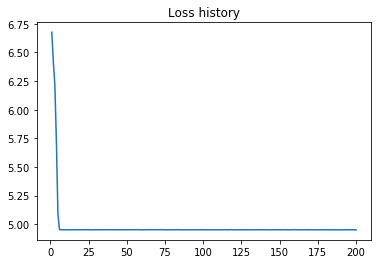

In [551]:
l = net_listD[1].plot_loss_history(log=True)

In [532]:
# Plotting helper function...
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(Ncol*4,15),Nrow*3), squeeze=False)
#     figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
                # print(result.shape)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
#                 axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
#         for i in range(Noutput):
#             axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
#             axst[i][j].legend(net_names)
            
    fig.suptitle(title)
#     figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs

<Figure size 432x288 with 0 Axes>

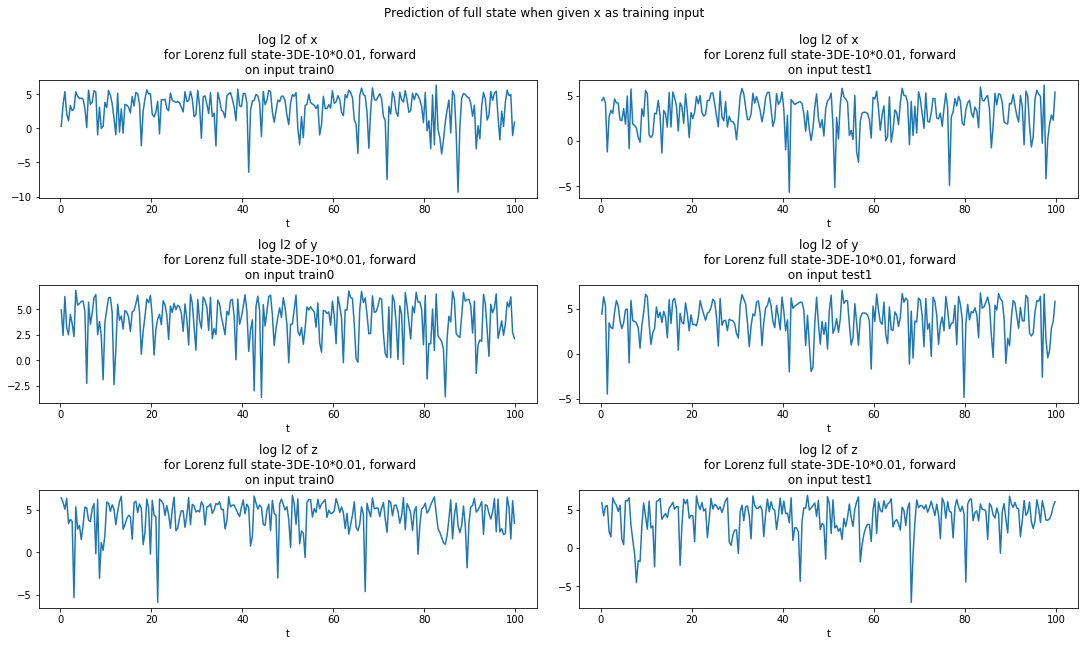

In [540]:
# Plot systems that try to learn the full state - error plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
                       datatype='l2', log_mode=True, plot_skip_rate=40, 
                       title='Prediction of full state when given x as training input\n' )

<Figure size 432x288 with 0 Axes>

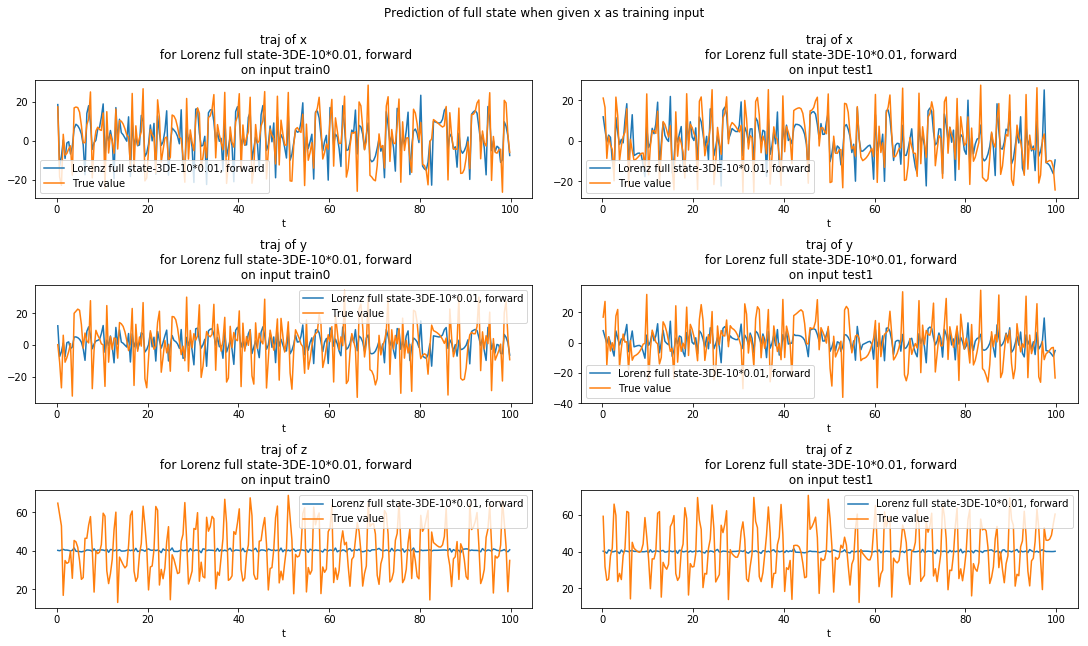

In [552]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
                       datatype='traj', log_mode=False, plot_skip_rate=40, 
                       title='Prediction of full state when given x as training input\n' )

<Figure size 432x288 with 0 Axes>

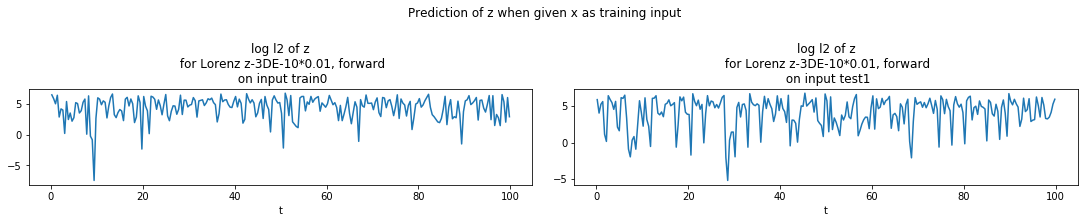

In [543]:
# Plot systems that try to learn z from x - error plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['z'],
                       datatype='l2', log_mode=True, plot_skip_rate=40, 
                       title='Prediction of z when given x as training input\n' )

<Figure size 432x288 with 0 Axes>

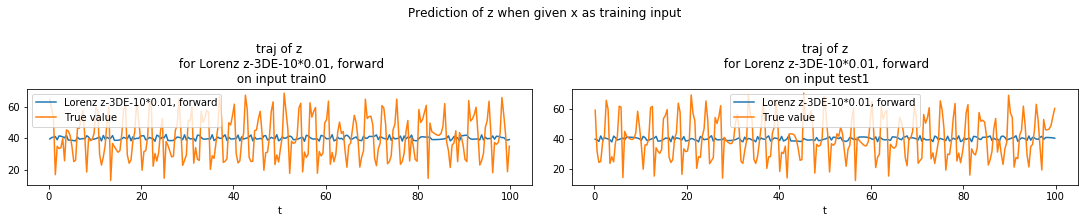

In [544]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['z'],
                       datatype='traj', log_mode=False, plot_skip_rate=40, 
                       title='Prediction of z when given x as training input\n' )

In [413]:
reload(embed_dynamics)

<module 'embed_dynamics' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/embed_dynamics.py'>

# Try out different Lorenz system results
## Same Lorenz system parameters, different initial values

In [414]:
t0 = 0
t1 = 100 # The original paper used 2000? 10000*0.02? They conflict with themselves.
dt = 0.01 # The original paper used 0.02, but I don't think it matters
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t, 
    lambda t : 0*t, 
    lambda t : 0*t
]
init_list = [ np.array([5, 0, 25]), np.array([-3, 5, 14]),
              np.array([15, -8, 55]), np.array([-12, -2, 3])]
u_names = ['.']*4

pred = 0

# Which parameters to use? Let's see what happens with Abarbanel's parameters first.
sigma=16
rho=45.92
beta=4
lorenz_sys = embed_dynamics.LorenzD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
# We also try to see if other state variables could be inferred.
lorenz_full_sys = embed_dynamics.LorenzFullStateD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
sys_list = [lorenz_sys, lorenz_full_sys]
sys_names = ['Lorenz z', 'Lorenz full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
    syst.data_generator()


In [411]:
dint1 = lorenz_sys.find_delay_from_MI(lorenz_sys.Inputset[0][1])
dint2 = lorenz_full_sys.find_delay_from_MI(lorenz_full_sys.Inputset[0][1])
print(dint1, dint2)

(10, True) (10, True)


In [ ]:
fig,axs = lorenz_full_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

In [416]:
# Set up nets.
# This is where we deviate from the original paper, which used polynomial approximations instead.
# Other discrepancies with the original paper:
# - This code doesn't do a train-test split because it's too cumbersome, given the current structure. 
# - This code might consider 1-step prediction and non-symmetric embedding as well. 
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [1] # Allows x(1); doesn't allow t(0), y(2), z(3), u(4).
Nlayer = 2
Nneuron = 5
# The delay and dimension come from the original paper.
de = 3
dint = [dint1[0], dint2[0]]

net_listD = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listD.append(
        networks.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=dint[i], sym=False
        )
    )
net_names = [ name+'-{0}DE-{1}*{2}, forward'.format(de, delay_int, dt) for name in sys_names]

# Construct models
for nn in net_listD:
    nn.construct()


In [417]:
# Train models. 
Epoch = 250
for nn in net_listD:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

20 0 9980 9980 9980
20 0 9980 9980 9980
20 0 9980 9980 9980
20 0 9980 9980 9980
Train on 9980 samples
Epoch 1/250
9980/9980 [==============================] - 1s 83us/sample - loss: 1735.2978
Epoch 2/250
9980/9980 [==============================] - 0s 32us/sample - loss: 1524.4587
Epoch 3/250
9980/9980 [==============================] - 0s 32us/sample - loss: 1261.1711
Epoch 4/250
9980/9980 [==============================] - 0s 33us/sample - loss: 1047.3976
Epoch 5/250
9980/9980 [==============================] - 0s 34us/sample - loss: 883.1541
Epoch 6/250
9980/9980 [==============================] - 0s 32us/sample - loss: 778.2105
Epoch 7/250
9980/9980 [==============================] - 0s 33us/sample - loss: 692.0523
Epoch 8/250
9980/9980 [==============================] - 0s 32us/sample - loss: 617.3538
Epoch 9/250
9980/9980 [==============================] - 0s 32us/sample - loss: 551.6072
Epoch 10/250
9980/9980 [==============================] - 0s 33us/sample - loss: 493.5042
Epo

In [ ]:
l = net_listD[1].plot_loss_history(log=True)

In [ ]:
# Plot systems that try to learn the full state - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['x','y','z'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )

In [ ]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['x','y','z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )

In [ ]:
# Plot systems that try to learn z from x - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['z'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Prediction of z when given x as training input\n' )

In [ ]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of z when given x as training input\n' )

## See if the method works on different Lorenz system parameters
Note: I'm checking different parameter sets separately. I know you can't use one system to predict another.

In [432]:
t0 = 0
t1 = 100 # The original paper used 2000? 10000*0.02? They conflict with themselves.
dt = 0.01 # The original paper used 0.02, but I don't think it matters
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t, 
    lambda t : 0*t, 
    lambda t : 0*t
]
init_list = [ np.array([5, 0, 25]), np.array([-3, 5, 14]),
              np.array([15, -8, 55]), np.array([-12, -2, 3])]
u_names = ['.']*4

pred = 0

# Which parameters to use? Trying different ones here.
# (sigma, rho, beta) = (16, 45.92, 4)
# (sigma, rho, beta) = (10, 28, 8/3) # Has the chaos
(sigma, rho, beta) = (10, 14, 8/3)
lorenz_sys = embed_dynamics.LorenzD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
# We also try to see if other state variables could be inferred.
lorenz_full_sys = embed_dynamics.LorenzFullStateD(t0=t0, tf=t1, dt=dt, noise=0, sigma=sigma, rho=rho, beta=beta, pred=pred)
sys_list = [lorenz_sys, lorenz_full_sys]
sys_names = ['Lorenz z', 'Lorenz full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
    syst.data_generator()


In [433]:
dint1 = lorenz_sys.find_delay_from_MI(lorenz_sys.Inputset[0][1])
dint2 = lorenz_full_sys.find_delay_from_MI(lorenz_full_sys.Inputset[0][1])
print(dint1, dint2)

(17, True) (18, True)


In [30]:
find_delay_from_MI(lorenz_sys.Inputset[0][1], method='kernel')

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [34]:
lorenz_sys.Inputset[0][1][:,[0]].shape

IndexError: too many indices for array

In [ ]:
fig,axs = lorenz_full_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

In [436]:
# Set up nets.
# This is where we deviate from the original paper, which used polynomial approximations instead.
# Other discrepancies with the original paper:
# - This code doesn't do a train-test split because it's too cumbersome, given the current structure. 
# - This code might consider 1-step prediction and non-symmetric embedding as well. 
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [1] # Allows x(1); doesn't allow t(0), y(2), z(3), u(4).
Nlayer = 2
Nneuron = 5
# The delay and dimension come from the original paper.
de = 3
dint = [dint1[0], dint2[0]]

net_listD = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listD.append(
        networks.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=dint[i], sym=False
        )
    )
net_names = [ name+'-{0}DE-{1}*{2}, forward'.format(de, delay_int, dt) for name in sys_names]

# Construct models
for nn in net_listD:
    nn.construct()


In [437]:
# Train models. 
Epoch = 250
for nn in net_listD:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

34 0 9966 9966 9966
34 0 9966 9966 9966
34 0 9966 9966 9966
34 0 9966 9966 9966
Train on 9966 samples
Epoch 1/250
9966/9966 [==============================] - 1s 117us/sample - loss: 105.1769
Epoch 2/250
9966/9966 [==============================] - 0s 39us/sample - loss: 48.1132
Epoch 3/250
9966/9966 [==============================] - 0s 45us/sample - loss: 26.9578
Epoch 4/250
9966/9966 [==============================] - 0s 44us/sample - loss: 14.6066
Epoch 5/250
9966/9966 [==============================] - 0s 34us/sample - loss: 7.3846
Epoch 6/250
9966/9966 [==============================] - 0s 32us/sample - loss: 3.4460
Epoch 7/250
9966/9966 [==============================] - 0s 33us/sample - loss: 1.5190
Epoch 8/250
9966/9966 [==============================] - 0s 36us/sample - loss: 0.6992
Epoch 9/250
9966/9966 [==============================] - 0s 36us/sample - loss: 0.4009
Epoch 10/250
9966/9966 [==============================] - 0s 32us/sample - loss: 0.3112
Epoch 11/250
9966/996

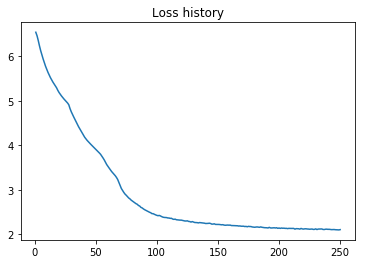

In [404]:
l = net_listD[1].plot_loss_history(log=True)

In [ ]:
# Plot systems that try to learn the full state - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['x','y','z'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )

In [ ]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['x','y','z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )

In [ ]:
# Plot systems that try to learn z from x - error plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['z'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Prediction of z when given x as training input\n' )

In [ ]:
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1,2,3], net_list=net_listD, net_inds=[0], out_list=[0], 
                       net_names=net_names, u_names=['train0','test1','test2','test3'], out_names=['z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of z when given x as training input\n' )

# Try false NN methods

In [215]:
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *
reload(embed_dynamics)

<module 'embed_dynamics' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/embed_dynamics.py'>

In [248]:
# find_delay_by_FNN(X, ratio=10, pred=1, stop_threshold=0, max_tau=100, max_dim=10, uniform_delay=True, 
#                      init_i=0, try_all_i=False, end_early=True, verbose=False)
find_delay_by_FNN_Garcia(X[[1]], ratio=10, pred=1, stop_threshold=0, max_tau=30, max_dim=10, uniform_delay=True,
                         init_i=0, end_early=True, verbose=True)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.06968420856195355; average d2 = 0.11774608829289585
49 out of 9968 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.09896129490169821; average d2 = 0.13158791177978088
26 out of 9968 samples counted as false neighbors
At delay=3 using j=0 for de=0: average d1 = 0.12035402798290967; average d2 = 0.146706023639754
42 out of 9968 samples counted as false neighbors
Found first local min at j=0, tau=2 as the 1-th delay
Updated F value from the 1-th embedding cycle is 0


([2], [0])

In [216]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_mask = [1] # Allows x(1); doesn't allow t(0), y(2), z(3), u(4).
Nlayer = 2
Nneuron = 5
# The delay and dimension come from the original paper.
de = 3
dint = [2, 2]

net_listD = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listD.append(
        embed_dynamics.NN_Delay(
            sys_list[i], input_mask, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg, 
            de=de, delay_int=dint[i], sym=False
        )
    )
net_names = [ sys_names[i]+'-{0}DE-{1}*{2}, forward'.format(de, dint[i], dt) for i in range(len(sys_names))]

# Construct models
for nn in net_listD:
    nn.construct()


In [ ]:
# Train models. 
Epoch = 200
for nn in net_listD:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

In [ ]:
# # Plot systems that try to learn the full state - error plot
# fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
#                        net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
#                        datatype='l2', log_mode=True, plot_skip_rate=100, 
#                        title='Prediction of full state when given x as training input\n' )
# Plot systems that try to learn the full state - trajectory plot
fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[1], out_list=[0,1,2], 
                       net_names=net_names, u_names=['train0','test1'], out_names=['x','y','z'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='Prediction of full state when given x as training input\n' )
# # Plot systems that try to learn z from x - error plot
# fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[0], out_list=[0], 
#                        net_names=net_names, u_names=['train0','test1'], out_names=['z'],
#                        datatype='l2', log_mode=True, plot_skip_rate=100, 
#                        title='Prediction of z when given x as training input\n' )
# # Plot systems that try to learn z from x - trajectory plot
# fig, axs = plot_tests( test_inds=[0,1], net_list=net_listD, net_inds=[0], out_list=[0], 
#                        net_names=net_names, u_names=['train0','test1'], out_names=['z'],
#                        datatype='traj', log_mode=False, plot_skip_rate=100, 
#                        title='Prediction of z when given x as training input\n' )

## Try with more variables / higher dimension observations

In [473]:
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *
reload(embed_dynamics)
reload(system_dynamics)

<module 'system_dynamics' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/system_dynamics.py'>

In [558]:
t0 = 0
t1 = 100 
dt = 0.01 
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t, 
    lambda t : 0*t
]
# init_list = [ np.ones(7), np.ones(7)+np.random.randn(7)*0.2 ]
# init_list = [ np.ones(7), np.array([-0.2, 1.5, -2.5, 0.41, -2.47, 1.47, -1.08]) ] # Gives linear asymptotic line??
init_list = [ np.ones(7), np.array([-0.20380494,  1.50691938, -2.49574082,  0.41356985, -2.47331202,
                                     1.47229205, -1.08367559]), 
              np.array([-0.2, 1.5, -2.5, 0.41, -2.47, 1.47, -1.08]) ]
u_names = ['.']
pred=1

gly_sys = embed_dynamics.GlycolyticFullState(t0=t0, tf=t1, dt=dt, pred=pred)#, output_inds=[0,1,2,3,4,5,6])
gly012_sys = embed_dynamics.GlycolyticFullState(t0=t0, tf=t1, dt=dt, pred=pred)#output_inds=[0,1,2,3,4,5,6], )
sys_list = [gly_sys, gly012_sys]
sys_names = ['Gly full state','Gly 012 state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
    syst.data_generator()


In [ ]:
glyyyy_sys = embed_dynamics.GlycolyticFullState(t0=t0, tf=t1, dt=dt, pred=pred)
glyyyy_sys.add_u_func( [u_func_list[0]], np.ones(7)*0.5+np.random.randn(7)*1.5 )
glyyyy_sys.data_generator()
glyyyy_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [483]:
glyyyy_sys.init

[array([-0.20380494,  1.50691938, -2.49574082,  0.41356985, -2.47331202,
         1.47229205, -1.08367559])]

<Figure size 432x288 with 0 Axes>

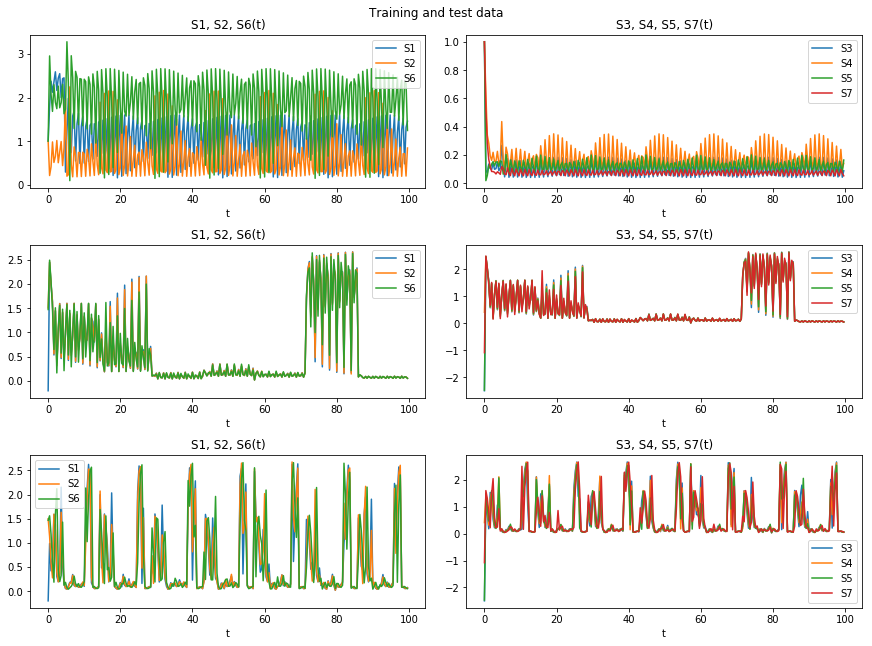

In [560]:
fig,axs = gly_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [300]:
# find_delay_by_FNN(X, ratio=10, pred=1, stop_threshold=0, max_tau=100, max_dim=10, uniform_delay=True, 
#                      init_i=0, try_all_i=False, end_early=True, verbose=False)
# Briefly test out the FNN method. Notice that the first row of Inputset[i] is time, and should be excluded.
find_delay_by_FNN_Garcia(gly_sys.Inputset[0][1:4,:], ratio=1.75, pred=1, stop_threshold=0, min_tau=1, max_tau=20, max_dim=10,
                         init_i=0, end_early=True, verbose=True)

Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.0034726025175464176; average d2 = 0.00354240982533228
0 out of 9978 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.0035698741543410194; average d2 = 0.003748708141764296
10 out of 9978 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.003031278611967357; average d2 = 0.00302333834756919
0 out of 9978 samples counted as false neighbors
At delay=2 using j=0 for de=0: average d1 = 0.003515380733460859; average d2 = 0.003595236477468298
1 out of 9978 samples counted as false neighbors
At delay=2 using j=1 for de=0: average d1 = 0.003665814401082166; average d2 = 0.0038070412491241685
30 out of 9978 samples counted as false neighbors
At delay=2 using j=2 for de=0: average d1 = 0.0030231761893481364; average d2 = 0.003019137758666462
0 out of 9978 samples counted as false neighbors
[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.0

([1], [0.0])

In [561]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_masks = [ [1,2,3,4,5,6,7], 
                [1,2,3] ] # Allows S1-S3
Nlayer = 2
Nneuron = 5

net_listF = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listF.append(
        embed_dynamics.NN_Garcia(
            sys_list[i], input_masks[i], ratio=1, stop_threshold=0, max_tau=20, max_de=10, verbose=True,
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, optimizer=opt_alg
        )
    )
net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listF:
    nn.construct()


Starting the 1-th embedding cycle
At delay=1 using j=0 for de=0: average d1 = 0.005486861094334958; average d2 = 0.0055055452556487415
3796 out of 9978 samples counted as false neighbors
At delay=1 using j=1 for de=0: average d1 = 0.005549147847784032; average d2 = 0.005584863261877384
5022 out of 9978 samples counted as false neighbors
At delay=1 using j=2 for de=0: average d1 = 0.00496869479256702; average d2 = 0.004966463457785075
5704 out of 9978 samples counted as false neighbors
At delay=1 using j=3 for de=0: average d1 = 0.004981982120431067; average d2 = 0.00497996637456349
3737 out of 9978 samples counted as false neighbors
At delay=1 using j=4 for de=0: average d1 = 0.004956630192725708; average d2 = 0.004954003003739517
4463 out of 9978 samples counted as false neighbors
At delay=1 using j=5 for de=0: average d1 = 0.005828574813422829; average d2 = 0.0059146244206606195
6809 out of 9978 samples counted as false neighbors
At delay=1 using j=6 for de=0: average d1 = 0.00496011

In [562]:
# Train models. 
Epoch = 100
for nn in net_listF:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Train on 9989 samples
Epoch 1/100
9989/9989 [==============================] - 4s 368us/sample - loss: 0.4566
Epoch 2/100
9989/9989 [==============================] - 0s 40us/sample - loss: 0.1278
Epoch 3/100
9989/9989 [==============================] - 0s 45us/sample - loss: 0.0808
Epoch 4/100
9989/9989 [==============================] - 0s 35us/sample - loss: 0.0609
Epoch 5/100
9989/9989 [==============================] - 0s 37us/sample - loss: 0.0523
Epoch 6/100
9989/9989 [==============================] - 0s 38us/sample - loss: 0.0471
Epoch 7/100
9989/9989 [==============================] - 0s 34us/sample - loss: 0.0428
Epoch 8/100
9989/9989 [==============================] - 0s 34us/sample - loss: 0.0386
Epoch 9/100
9989/9989 [==============================] - 0s 35us/sample - loss: 0.0349
Epoch 10/100
9989/9989 [==============================] - 0s 34us/sample - loss: 0.0318
Epoch 11/100
9989/9989 [==============================] - 0s 34us/sample - loss: 0.0295
Epoch 12/100
9989/

In [454]:
gly_sys.Inputset[0].shape

(9, 10000)

In [563]:
# Plotting helper function...
# This one is modified to suite FNN. Don't remove it too soon. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title=''):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(Ncol*4,15),Nrow*3), squeeze=False)
#     figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
#             time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
#                 print(time_series)
#                 print(result.shape)
#                 print(n, i, n + len(net_inds)*i, j)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
                # Also draw this network's plot onto the overlay plots over all networks
#                 axst[i][j].plot(time_series[::plot_skip_rate], result[::plot_skip_rate,ii])
        
#         for i in range(Noutput):
#             axst[i][j].set_title( datatype+' of '+out_names[i]+'\n on input '+u_names[jj] )
#             axst[i][j].legend(net_names)
            
    fig.suptitle(title)
#     figt.suptitle('Overlaying result for '+title)
    return fig, axs

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1):
    axs.plot(time[::skip], data[::skip])
#     print(time.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[::skip], data2[::skip])
        axs.legend(leglist)
    return axs

In [ ]:
fig, axs = plot_tests( test_inds=[0,1,2], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=['train0','test1','test2'], out_names=['S1','S2','S3','S4','S5','S6','S7'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S7 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9985, 7, 1), results = (9985, 7, 1)


<Figure size 432x288 with 0 Axes>

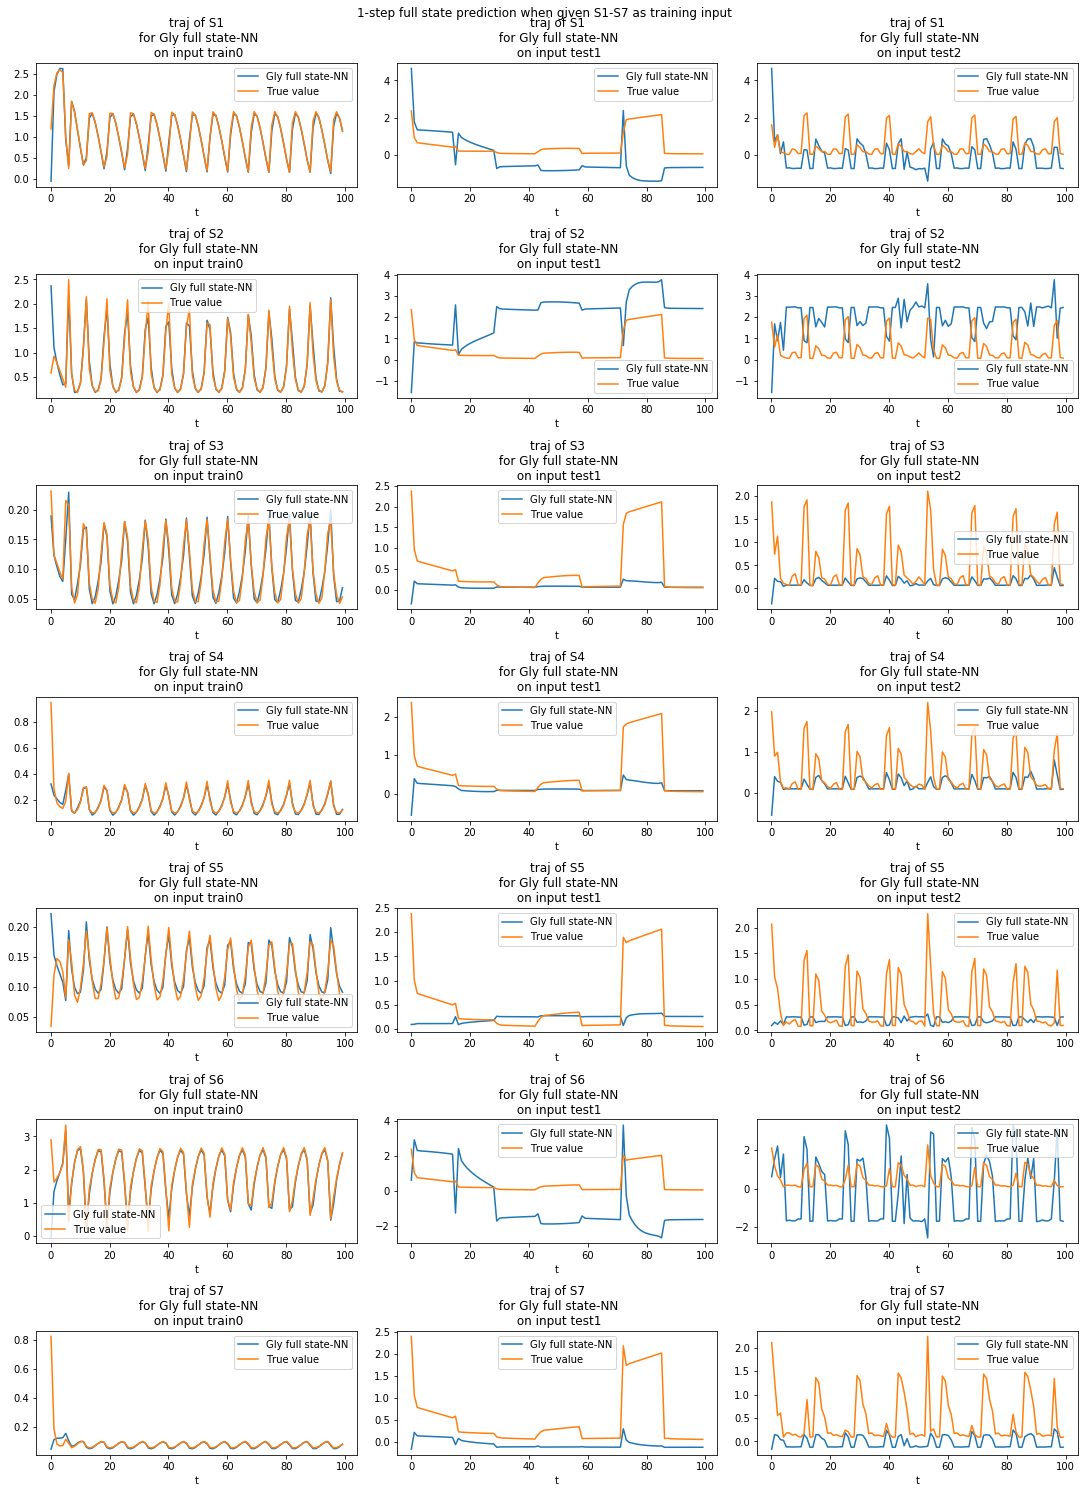

In [565]:
fig, axs = plot_tests( test_inds=[0,1,2], net_list=net_listF, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=['train0','test1','test2'], out_names=['S1','S2','S3','S4','S5','S6','S7'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S7 as training input\n' )

In [ ]:
fig, axs = plot_tests( test_inds=[0,1,2], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=['train0','test1','test2'], out_names=['S1','S2','S3','S4','S5','S6','S7'],
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9985, 7, 1), results = (9985, 7, 1)


<Figure size 432x288 with 0 Axes>

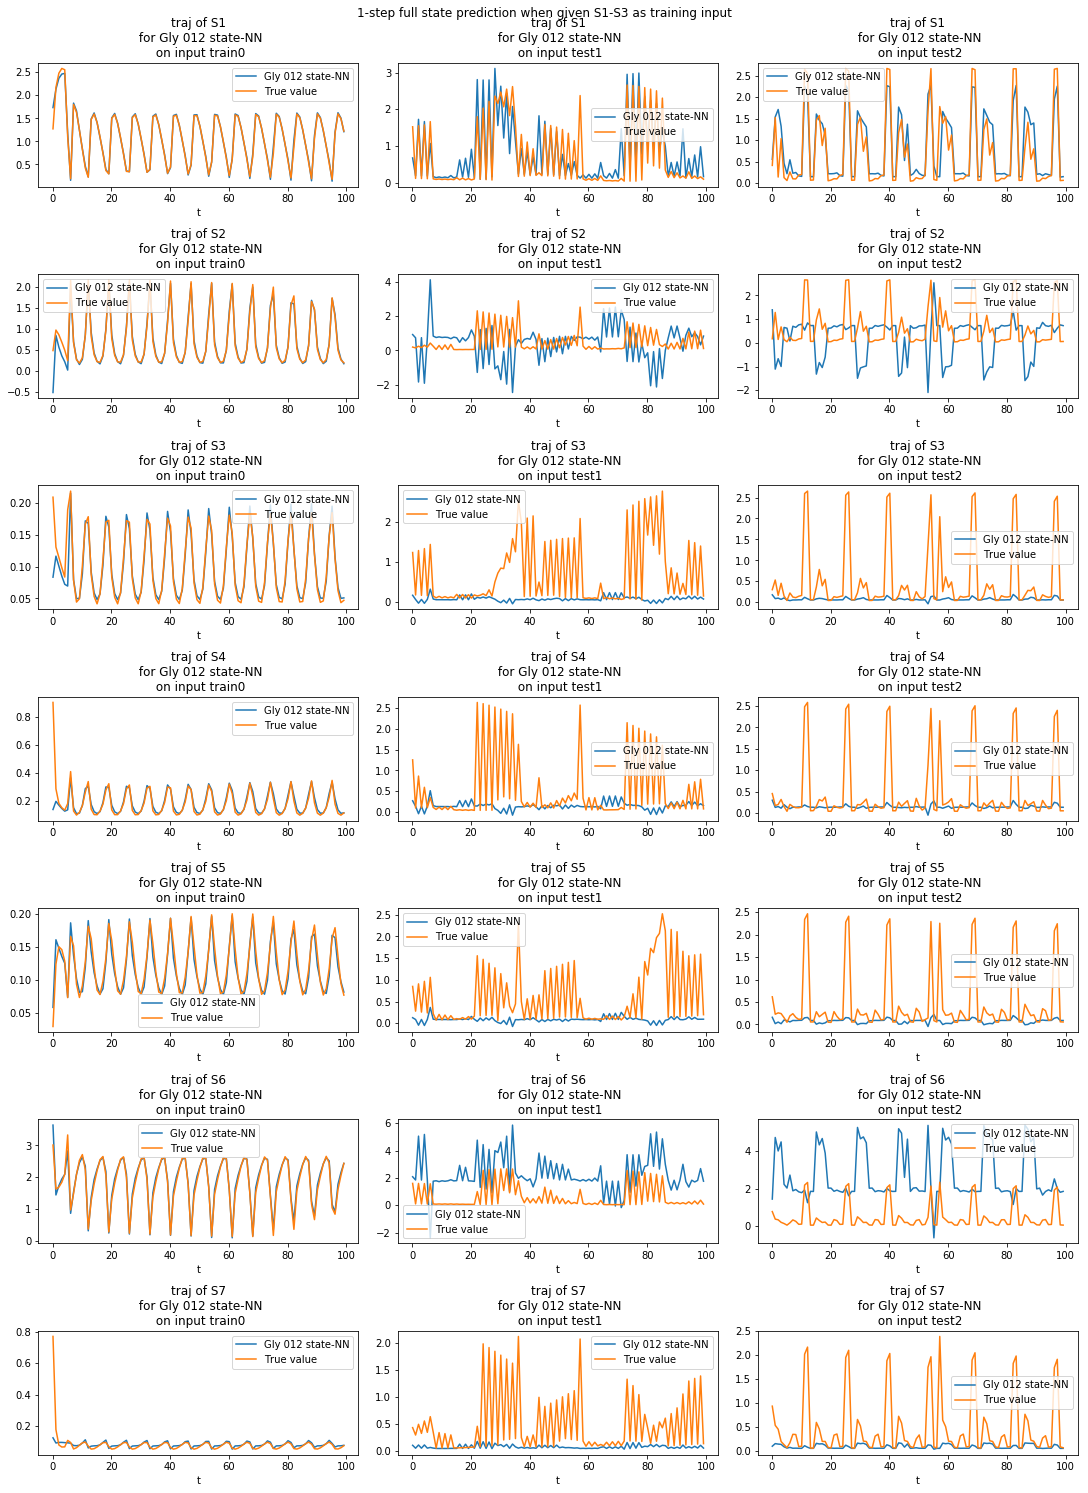

In [566]:
fig, axs = plot_tests( test_inds=[0,1,2], net_list=net_listF, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=['train0','test1','test2'], out_names=['S1','S2','S3','S4','S5','S6','S7'],
                       datatype='traj', log_mode=False, plot_skip_rate=100, 
                       title='1-step full state prediction when given S1-S3 as training input\n' )

In [400]:
dinn, doutt = delay_embed_Garcia(
    net_listF[0].js, net_listF[0].tts, [i[1:4,:] for i in gly_sys.Inputset], gly_sys.Outputset, pred)

In [420]:
net_listF[0].dynamics.Inputset[1][0]

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01])

In [395]:
(Iset, Oset) = net_listF[0].train_data_generation_helper()

In [465]:
net_listF[0].js, net_listF[0].ts

([0], [4])

In [397]:
Oset.shape

(19990, 7, 1)

In [409]:
net_listF[0].output_shape

In [51]:
find_delay_from_MI(lorenz_sys.Inputset[0][1], method='kernel')

(11, True)

In [304]:
np.sum(aaab, axis=0)

array([[12, 14, 16, 18],
       [20, 22, 24, 26],
       [28, 30, 32, 34]])

In [20]:
np.linspace(np.array([1,2]), np.array([5,6]), num=10).T

array([[1.        , 1.44444444, 1.88888889, 2.33333333, 2.77777778,
        3.22222222, 3.66666667, 4.11111111, 4.55555556, 5.        ],
       [2.        , 2.44444444, 2.88888889, 3.33333333, 3.77777778,
        4.22222222, 4.66666667, 5.11111111, 5.55555556, 6.        ]])

In [9]:
entropy(np.vstack((prob1sc, prob2sc)), np.vstack((prob1sk, prob2sk, prob2sc)), axis=1)

ValueError: qk and pk must have same shape.

In [5]:
X = lorenz_sys.Inputset[0]

In [6]:
testset = np.arange(-30, 30, 1)

sckde1 = gaussian_kde(X[1])
sckde2 = gaussian_kde(X[2])
sckde3 = gaussian_kde(X[3])
prob1sc = sckde1.pdf(testset)
prob2sc = sckde2.pdf(testset)
prob3sc = sckde3.pdf(testset)

skkde1 = KernelDensity(kernel='gaussian', bandwidth=2).fit(X[1].reshape(-1,1)) # Bandwidth needs tuning
skkde2 = KernelDensity(kernel='gaussian', bandwidth=2).fit(X[2].reshape(-1,1)) # Bandwidth needs tuning
skkde3 = KernelDensity(kernel='gaussian', bandwidth=2).fit(X[3].reshape(-1,1)) # Bandwidth needs tuning
prob1sk = np.exp(skkde1.score_samples(testset.reshape(-1,1)))
prob2sk = np.exp(skkde2.score_samples(testset.reshape(-1,1)))
prob3sk = np.exp(skkde3.score_samples(testset.reshape(-1,1)))

In [51]:
reload(embedding_methods)

NameError: name 'embedding_methods' is not defined

In [148]:
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *

In [74]:
AMI(X[[1],:],X[[2],:], method='kernel')

(2, 50) [1.15954315 1.56559765]


0.902296318316449

In [149]:
find_delay_from_MI(X[1], start_delay=7, max_delay=15, method='kernel', end_early=False, verbose=True)

shape is  (1, 10000)
(2, 50) [1.15954315 1.15954315]
At delay = 7, the AMI is 0.8507007162329243.
(2, 50) [1.15954315 1.15954315]
At delay = 8, the AMI is 0.7921261566535422.
(2, 50) [1.15954315 1.15954315]
At delay = 9, the AMI is 0.7520378790137423.
(2, 50) [1.15954315 1.15954315]
At delay = 10, the AMI is 0.7290853218318252.
(2, 50) [1.15954315 1.15954315]
At delay = 11, the AMI is 0.7213313463760369.
(2, 50) [1.15954315 1.15954315]
At delay = 12, the AMI is 0.7251483755973567.
11 is the optimal delay it found.
(2, 50) [1.15954315 1.15954315]
At delay = 13, the AMI is 0.734758942168749.
11 is the optimal delay it found.
(2, 50) [1.15954315 1.15954315]
At delay = 14, the AMI is 0.744584307433604.
11 is the optimal delay it found.
(2, 50) [1.15954315 1.15954315]
At delay = 15, the AMI is 0.7532572434472189.
11 is the optimal delay it found.


(11, True)

In [186]:
aaa[[3]]

array([[-31.36619336, -76.5696588 , 114.21941695, -10.89616167]])

In [177]:
np.concatenate( (np.array([1,2,3]), 4,5,6) )

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [183]:
argrelextrema(aaa[:,2], np.less, axis=0)[0].tolist()

[2]

In [88]:
np.sum(aaa, axis=tuple(np.array([0,3])))

array([[ 99, 111, 123, 135],
       [147, 159, 171, 183]])

In [172]:
find_peaks(-aaa[:,2])

(array([2]), {})

In [86]:
ccc = np.arange(10)
ccc[ np.array([True, True,False, False, True, True, True,False, False, True]) ]

array([0, 1, 4, 5, 6, 9])

In [90]:
axis_TF = [[True, False]] * 4
meshes = np.meshgrid( *axis_TF )

In [95]:
coords = np.vstack( [mesh.ravel() for mesh in meshes] )

In [103]:
[(coords[:,i], np.count_nonzero(coords[:,i])) for i in range(coords.shape[1])]

[(array([ True,  True,  True,  True]), 4),
 (array([ True,  True,  True, False]), 3),
 (array([ True,  True, False,  True]), 3),
 (array([ True,  True, False, False]), 2),
 (array([False,  True,  True,  True]), 3),
 (array([False,  True,  True, False]), 2),
 (array([False,  True, False,  True]), 2),
 (array([False,  True, False, False]), 1),
 (array([ True, False,  True,  True]), 3),
 (array([ True, False,  True, False]), 2),
 (array([ True, False, False,  True]), 2),
 (array([ True, False, False, False]), 1),
 (array([False, False,  True,  True]), 2),
 (array([False, False,  True, False]), 1),
 (array([False, False, False,  True]), 1),
 (array([False, False, False, False]), 0)]

In [112]:
Xd = framing_helper(X[[1],:], 7, interv=1, stride=4, axis=1)

In [113]:
Xd.shape

(9976, 1, 7)

In [114]:
np.linalg.norm(Xd, axis=1).shape

(9976, 7)

In [115]:
np.sum(Xd)

89424.61880785078

In [117]:
aaab = np.arange(24).reshape((2,3,4))
baa = np.arange(6).reshape((2,3,1))
aaab, baa, aaab-baa

(array([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],
 
        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]]), array([[[0],
         [1],
         [2]],
 
        [[3],
         [4],
         [5]]]), array([[[ 0,  1,  2,  3],
         [ 3,  4,  5,  6],
         [ 6,  7,  8,  9]],
 
        [[ 9, 10, 11, 12],
         [12, 13, 14, 15],
         [15, 16, 17, 18]]]))

In [121]:
np.linalg.norm(np.linalg.norm(aaab-baa, axis=1), axis=1)

array([18.16590212, 47.68647607])

In [122]:
abab = np.arange(24).reshape(4,6)

In [140]:
abab[ [0,1,2,3] ]

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17],
       [18, 19, 20, 21, 22, 23]])

In [143]:
np.hstack([ abab[:,[3]], abab[:,[1]] ])

array([[ 3,  1],
       [ 9,  7],
       [15, 13],
       [21, 19]])

In [214]:
net_listM[0].Inputset[0].shape
# net_listM[0].input_mask
# net_listM[0].Inputset[0][:,net_listM[0].input_mask,:].shape
# net_listM[0].de

(9970, 8, 1)

In [215]:
net_listM[1].Inputset[0][:,input_masks[0]].shape
# net_listM[1].input_shape

(9980, 2, 3)

In [224]:
net_listM[0].Inputset[0][:9970,6,0], net_listM[1].Inputset[0][:,input_masks[0]][:9970,1,2]

(array([36.010226  , 41.42604629, 47.37455218, ..., 37.96996981,
        36.84528751, 35.82704136]),
 array([36.010226  , 41.42604629, 47.37455218, ..., 37.96996981,
        36.84528751, 35.82704136]))

In [235]:
# Plotting helper function...
# This one is modified to suite FNN. Don't remove it too soon. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title='', maxtime=None):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = [nn.test(inds=test_inds,squeeze=False) for nn in net_list]
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(15,Ncol*4),Nrow*3), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
#             time_series = results_list[nn][2][jj][:,0,-1]
            # Above: [nn] - Take the nn-th network's result; [2] - The 3rd element in result is Inputset;
            #        [jj] - Take the jj-th test run's result; 
            #        [:,0,-1] means take all frames(:), first row (0, where we stored time), last value (-1),
            #          where we take the last value because that's where the output data matches.
            
            # Find the correct thing that we want to plot.
            if datatype == 'l2':
                result = np.square(results_list[nn][0][jj] - results_list[nn][1][jj])
            elif datatype == 'l1':
                result = np.abs(results_list[nn][0][jj] - results_list[nn][1][jj])
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_list[nn][0][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                # print(results_list[nn][1][jj].shape)
#                 print(time_series)
#                 print(result.shape)
#                 print(n, i, n + len(net_inds)*i, j)
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = results_list[nn][1][jj][:,ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate, maxtime=maxtime
                )
                #print(n + len(net_inds)*i, j, result[:,ii].shape)
                
    fig.suptitle(title)
    return fig, axs, results_list

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1, maxtime=None):
    if maxtime is None:
        maxtime = len(time)
    else:
        maxtime = int(maxtime)
#         axs.plot(time[::skip], data[::skip])
#     else:
#         axs.plot(time[:maxtime:skip], data[:maxtime:skip])
    axs.plot(time[:maxtime:skip], data[:maxtime:skip])
#     print(time.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype == 'traj':
        axs.plot(time[:maxtime:skip], data2[:maxtime:skip])
#         if maxtime is None:
#             axs.plot(time[::skip], data2[::skip])
#         else:
#             axs.plot(time[:maxtime:skip], data[:maxtime:skip])
        
        axs.legend(leglist)
    return axs

In [353]:
# isinstance(tf.keras.losses.mean_squared_error, callable)
# hasattr(tf.keras.losses.mean_squared_error, '__call__')
# type(tf.keras.losses.mean_squared_error)

# rlist[0]: Results that didn't work. Comes from net_listM[0] using NN_FNN.
# rlist[1]: Results that did work. Comes from net_listM[1] using NN_Delay.
# Compare their values previous to normalization, and see what's wrong here.
# net_listM[0].input_norm_params[1], net_listM[1].input_norm_params[1][input_masks[0]]
# net_listM[0].output_norm_params, net_listM[1].output_norm_params
rlist[0][0][0][:,2,0], rlist[1][0][0][:,2,0] # This line checks prediction values of the not-working net ([0])
# and the working net ([1])'s prediction ([0]) on the first dynamics data ([0]) for the 3rd variable (2).
# Note: rlist[0]'s time starts at 0.3, while rlist[1] starts at 0.2. Make sure you start rlist[1] 10 samples later.

# rlist[0][2][0].shape, rlist1[1][2][0].shape
# net_listM[0].Inputset[0][:9970,6,0], net_listM[1].Inputset[0][:,input_masks[0]][:9970,1,2] # Compare input sets
# i00 = np.concatenate(net_listM[0].Inputset)
# i11 = np.concatenate(net_listM[1].Inputset)
i00.shape, i11.shape
# i00[:9000, 0, 0], i11[10:9010, 1, 0]
# i00, i11
i00[:9000, 0, 0], i11[0:9000, 1, 0]

# rlist[0][2][0][:,6,0], rlist[1][2][0][10:,1,2] # Compare their inputs
# r00 = normalize(rlist[0][2][0], axis=1, params=net_listM[0].input_norm_params)[0]
# r11 = normalize(rlist[1][2][0], axis=1, params=net_listM[1].input_norm_params)[0]
# r00[:,6,0], rlist[0][2][0][:,6,0], r11[10:,1,2], rlist[1][2][0][10:,1,2]
# rlist[0][2][0][0], rlist1[1][2][0][0]
# np.all(rlist[0][2][0][:9970,0,0] == rlist1[1][2][0][:9970,0,0]) # Check that they have the same Inputset ([2])
# rlist[0][2][0][:1000,0,0], rlist[1][2][0][:1000,0,0]
# np.all(rlist[0][0][0] == rlist1[1][0][0]) # Check that they have the same result/prediction
# np.all(rlist[0][1][0] == rlist1[1][1][0]) # Check that they have the same Outputset ([1])
# np.all(rlist[0][3][0] == rlist1[1][3][0]) # Check that they have the same Timeset ([3])
# rlist[0][3][0][:1000], rlist[1][3][0][:1000]
# np.all(rlist[0][0][2] == rlist1[1][0][2])
# np.linalg.norm( rlist1[0][0][0] - rlist1[0][1][0] ) # Difference between prediction ([0]) and actual outcome ([1])
# np.linalg.norm( rlist[0][0][0] - rlist[0][1][0] )

# fig,axs = plt.subplots(1, 1, constrained_layout=True, figsize = (4,3), squeeze=False)
# n, nn, j, jj, i, ii = (0,0,0,0,0,0)
# time_series = np.squeeze(rlist[nn][3][jj])
# # result = np.square(rlist[nn][0][jj] - rlist[nn][1][jj])
# result = rlist[nn][0][jj]
# make_axs_plot(      axs = axs[0][0], time = time_series, data = result[:,ii],
#                     title = '???',
#                     datatype = 'traj', data2 = rlist[nn][1][jj][:,ii], 
#                     leglist = [net_names[nn], 'True value'], skip = 1, maxtime=1000
#                 )

(array([  5.        ,   4.33710343,   3.91136823, ..., -20.72398052,
        -20.78414486, -20.51706348]),
 array([  5.        ,   4.33710343,   3.91136823, ..., -20.72398052,
        -20.78414486, -20.51706348]))

In [356]:
ab, pb = normalize(i00[:9000, [0], [0]], axis=1)

In [357]:
normalize(ab, axis=1, params=pb, reverse=True)

(array([[  5.        ],
        [  4.33710343],
        [  3.91136823],
        ...,
        [-20.72398052],
        [-20.78414486],
        [-20.51706348]]), (array([1.28395656]), array([12.60734661])))

In [359]:
inputsets0 = [normalize( inputset[net_listM[0].input_mask,:], axis=0,
                                params=net_listM[0].input_norm_params)[0] for inputset in net_listM[0].dynamics.Inputset]

In [362]:
(Inputset0, Outputset0, Timeset0) = net_listM[0].delay_embed_fnn(inputsets0)

In [371]:
(Inputset1, Outputset1) = delay_embed(net_listM[1].delay_int, net_listM[1].de, 
                                    net_listM[1].dynamics.Inputset, net_listM[1].dynamics.Outputset, net_listM[1].pred)
Timeset1 = [inp[:,0,-1] for inp in Inputset1]

In [375]:
Inputset1 = [normalize_frame(inputset, params=net_listM[1].input_norm_params)[0][:,
                             net_listM[1].input_mask,:] for inputset in Inputset1]

In [380]:
Inputset0[0][:,3,:], Inputset1[0][10:,0,2]

(array([[ 1.27040994],
        [ 1.05272361],
        [ 0.84011205],
        ...,
        [-0.92870425],
        [-0.99732114],
        [-1.07089104]]),
 array([ 1.26961226,  1.05200673,  0.83947409, ..., -0.92868562,
        -0.99727705, -1.07081964]))

In [366]:
# Inputset0[0] == rlist[0][2][0]
Inputset0[0].shape

(9970, 8, 1)

In [378]:
net_listM[0].input_norm_params, net_listM[1].input_norm_params

((array([ 1.27711457,  1.28902401,  1.27610314,  1.24376089, 40.07379744,
         40.11511276, 40.13487202, 40.11082699]),
  array([12.60390438, 12.61435809, 12.61078217, 12.59508916, 13.46014321,
         13.4675748 , 13.45557051, 13.44172193])),
 (array([49.995     ,  1.28122637,  1.27197595, 40.11371604,  0.        ]),
  array([28.80989399, 12.60858468, 14.41689053, 13.46205322,  0.        ])))

In [379]:
rlist[1][2][0]

array([[[-1.78955153, -1.78873074, -1.77150942],
        [ 0.04758142,  0.00706797,  0.1168384 ]],

       [[-1.79035019, -1.78782728, -1.76915062],
        [ 0.04155707,  0.0065007 ,  0.15090521]],

       [[-1.79086312, -1.78676264, -1.76703273],
        [ 0.03599193,  0.00719759,  0.18832275]],

       ...,

       [[-1.78435759, -1.80071533, -1.80813948],
        [ 0.24863807,  0.12916566,  0.09507467]],

       [[-1.7872762 , -1.80140698, -1.80918144],
        [ 0.23108175,  0.12209113,  0.09794157]],

       [[-1.78985295, -1.80206009, -1.81029862],
        [ 0.21502137,  0.11568612,  0.10252847]]])

In [377]:
Inputset1[0]

array([[[ 0.29493981,  0.34897144,  1.48263288],
        [-1.12269026, -1.60112257, -0.30481903]],

       [[ 0.2423648 ,  0.40844523,  1.63791037],
        [-1.19383307, -1.60782169,  0.09748366]],

       [[ 0.20859929,  0.47852976,  1.77732863],
        [-1.25955306, -1.59959194,  0.53935578]],

       ...,

       [[ 0.63685153, -0.43996177, -0.92868562],
        [ 1.25163295, -0.15924363, -0.56183181]],

       [[ 0.44472263, -0.48549242, -0.99727705],
        [ 1.04430639, -0.24278826, -0.5279759 ]],

       [[ 0.27509771, -0.52848595, -1.07081964],
        [ 0.85464569, -0.31842651, -0.47380818]]])

In [368]:
Inputset0[0]

array([[[ 0.29537557],
        [ 0.34942726],
        [ 1.48350967],
        ...,
        [ 1.36909818],
        [ 2.75251438],
        [ 5.02694133]],

       [[ 0.24278103],
        [ 0.40892313],
        [ 1.63884482],
        ...,
        [ 1.36194888],
        [ 3.18185214],
        [ 4.81099226]],

       [[ 0.20900299],
        [ 0.47903369],
        [ 1.77831485],
        ...,
        [ 1.37073168],
        [ 3.65341842],
        [ 4.58219894]],

       ...,

       [[ 1.91546861],
        [ 0.63741424],
        [-0.43979892],
        ...,
        [ 4.4135612 ],
        [ 2.90787256],
        [ 2.47823013]],

       [[ 1.99766275],
        [ 0.445214  ],
        [-0.48534647],
        ...,
        [ 4.19230213],
        [ 2.81871366],
        [ 2.51436119]],

       [[ 2.02389228],
        [ 0.27552609],
        [-0.52835596],
        ...,
        [ 3.98989607],
        [ 2.73799246],
        [ 2.57216902]]])

In [330]:
net_listM[1].input_norm_params
data = rlist[1][2][0]
Nfeats = data.shape[1]
rlist[1][2][0].shape[0]
data = np.swapaxes(data, 1, 0)
data.shape

(2, 9980, 3)

In [331]:
params = net_listM[1].input_norm_params
for i in range(Nfeats):
    data[i] = (data[i] - params[0][i]) / params[1][i]

In [398]:
rlist[1][2][0][:-10,0,0]

array([0.29493981, 0.2423648 , 0.20859929, ..., 1.91443147, 1.99659511,
       2.0228149 ])

In [397]:
rlist[0][2][0][:,0,0]

array([0.29537557, 0.24278103, 0.20900299, ..., 1.91546861, 1.99766275,
       2.02389228])

In [338]:
aaa = np.arange(108).reshape(9,3,4)
normalize(aaa,1)

(array([[[-1, -1, -1, -1],
         [-1, -1, -1, -1],
         [-1, -1, -1, -1]],
 
        [[-1, -1, -1, -1],
         [-1, -1, -1, -1],
         [-1, -1, -1, -1]],
 
        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],
 
        [[ 1,  1,  1,  1],
         [ 1,  1,  1,  1],
         [ 1,  1,  1,  1]],
 
        [[ 1,  1,  1,  1],
         [ 1,  1,  1,  1],
         [ 1,  1,  1,  1]]]),
 (array([49.5, 53.5, 57.5]), array([31.004032, 31.004032, 31.004032])))

In [254]:
net_listM[0].FNNargs

array([[10, 20, 30],
       [10, 20, 30]])